# Tesla_Insights_Pinnacle

![Tesla Logo](tesla_logo.png)

Mi chiamo **Raffaele Schiavone**. In questo progetto finale dimostro il mio approccio end-to-end, integrando competenze avanzate in Data Engineering, Data Analysis, Machine Learning, Forecasting, Deep Learning, API AI, SQL, Python e R. 

Il progetto copre:
- Raccolta dei dati storici di TSLA (dal 30/06/2010 ad oggi) e salvataggio in CSV e in un database SQL
- Feature Engineering e Analisi Esplorativa Avanzata
- Implementazione e tuning di modelli predittivi (RandomForest, ensemble avanzato, Prophet e LSTM)
- Interpretabilità con SHAP
- Tracking MLOps con MLflow
- Creazione di un'API AI con FastAPI per sentiment analysis e summarization
- Integrazione di dati esterni (indicatori macroeconomici e feedback/sentiment) tramite API
- Dashboard interattiva per la visualizzazione dinamica, esportabile in JSON per Tableau Public

Questo progetto rappresenta a mio avviso un ottimo esercizio e la dimostrazione completa delle mie competenze avanzate.

## 1. Setup e Configurazione

Assicurati di aver creato un ambiente virtuale ed installato le seguenti librerie (consulta `requirements.txt` per la lista completa):

```bash
pip install yahooquery pandas matplotlib seaborn scikit-learn xgboost statsmodels prophet tensorflow keras fastapi uvicorn pydantic mlflow sqlalchemy rpy2 tf-keras plotly dash requests
```

Inoltre, attiva Developer Mode su Windows se necessario per supportare funzionalità avanzate (come rpy2).

In [1]:
# Imposta i warning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import time
import random
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

BASE_DIR = os.getcwd()
print(f"[INFO] Directory di lavoro: {BASE_DIR}")

# Verifica presenza di tf-keras per la compatibilità
try:
    import tf_keras
except ModuleNotFoundError:
    print("[ERROR] tf-keras non è installato. Installa con: pip install tf-keras")
    raise

[INFO] Directory di lavoro: C:\Users\raffa\Downloads\Data Scientist - Data Analyst - Data Engenieer - AI Expert\Tesla_Insights_Pinnacle



## 2. Data Engineering & Raccolta Dati

Scarichiamo i dati storici di TSLA (già salvati in `tsla_yahooquery.csv`) e li carichiamo in un database SQL.

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Carica il file CSV contenente i dati di TSLA
try:
    tsla_data = pd.read_csv("tsla_yahooquery.csv")
    print("[INFO] CSV 'tsla_yahooquery.csv' caricato correttamente.")
except Exception as e:
    print("[ERROR] Impossibile caricare il file CSV:", e)
    raise

# Crea un engine per SQLite; questo creerà (o aprirà) un database file-based chiamato 'tesla.db'
try:
    engine = create_engine('sqlite:///tesla.db')
    print("[INFO] Engine creato per SQLite (tesla.db).")
except Exception as e:
    print("[ERROR] Impossibile creare l'engine SQLite:", e)
    raise

# Utilizza raw_connection per ottenere una connessione che supporta il metodo cursor, necessario per pandas.to_sql
try:
    conn = engine.raw_connection()
    print("[INFO] Connessione raw ottenuta dall'engine.")
except Exception as e:
    print("[ERROR] Impossibile ottenere una connessione raw:", e)
    raise

# Scrivi i dati nella tabella 'tsla_data' nel database SQLite utilizzando il metodo to_sql
try:
    tsla_data.to_sql('tsla_data', conn, if_exists='replace', index=False)
    conn.commit()
    print("[INFO] Dati salvati nel database SQLite 'tesla.db' nella tabella 'tsla_data'.")
except Exception as e:
    print("[ERROR] Errore durante il salvataggio dei dati nel database:", e)
    conn.rollback()
    raise
finally:
    conn.close()
    print("[INFO] Connessione chiusa correttamente.")

[INFO] CSV 'tsla_yahooquery.csv' caricato correttamente.
[INFO] Engine creato per SQLite (tesla.db).
[INFO] Connessione raw ottenuta dall'engine.
[INFO] Dati salvati nel database SQLite 'tesla.db' nella tabella 'tsla_data'.
[INFO] Connessione chiusa correttamente.


C:\Users\raffa\AppData\Local\Temp\ipykernel_23120\1011151723.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tsla_data.to_sql('tsla_data', conn, if_exists='replace', index=False)


## 3. Feature Engineering & Analisi Esplorativa (EDA)

Calcoliamo le feature tecniche principali: **Daily Return**, **Medie Mobili (MA20, MA50)**, **Volatilità** e **RSI**. Visualizziamo grafici e statistiche descrittive.

[INFO] Colonne disponibili: ['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'splits']
[INFO] Feature Engineering completato.
         date     close  Daily Return  MA20  MA50  Volatility  RSI
0  2010-06-30  1.588667           NaN   NaN   NaN         NaN  NaN
1  2010-07-01  1.464000     -0.078473   NaN   NaN         NaN  NaN
2  2010-07-02  1.280000     -0.125683   NaN   NaN         NaN  NaN
3  2010-07-06  1.074000     -0.160937   NaN   NaN         NaN  NaN
4  2010-07-07  1.053333     -0.019243   NaN   NaN         NaN  NaN


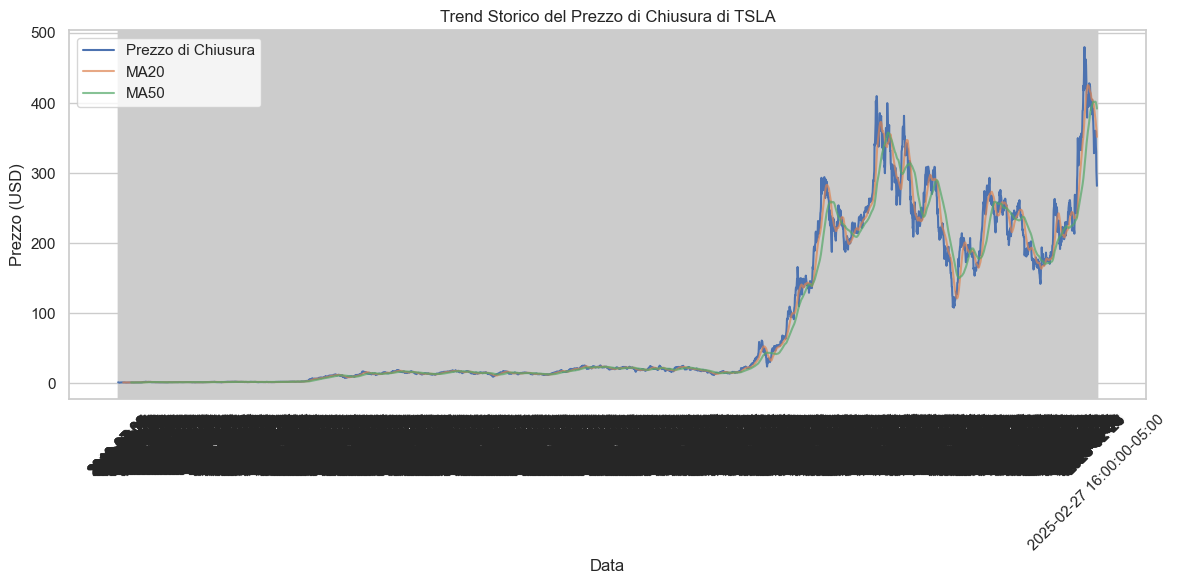

[INFO] Statistiche descrittive:
              open         high          low        close        volume  \
count  3689.000000  3689.000000  3689.000000  3689.000000  3.689000e+03   
mean     84.636129    86.490924    82.634109    84.591122  9.643604e+07   
std     111.347011   113.827549   108.583325   111.216103  7.732919e+07   
min       1.076000     1.108667     0.998667     1.053333  1.777500e+06   
25%      12.239333    12.448667    12.015333    12.226667  4.935750e+07   
50%      18.316668    18.639999    17.902666    18.322001  8.192850e+07   
75%     182.860001   186.220001   178.419998   182.630005  1.216350e+08   
max     475.899994   488.540009   457.510010   479.859985  9.140820e+08   

          adjclose       splits  Daily Return         MA20         MA50  \
count  3689.000000  3689.000000   3688.000000  3670.000000  3640.000000   
mean     84.591122     0.002169      0.002055    84.160864    83.232822   
std     111.216103     0.095992      0.036162   110.235428   108.03

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Data = pd.read_csv("tsla_yahooquery.csv")
print("[INFO] Colonne disponibili:", Data.columns.tolist(), flush=True)

# Calcolo del Daily Return sulla colonna 'close'
Data["Daily Return"] = Data["close"].pct_change()

# Calcolo delle medie mobili
Data["MA20"] = Data["close"].rolling(window=20).mean()
Data["MA50"] = Data["close"].rolling(window=50).mean()

# Calcolo della volatilità
Data["Volatility"] = Data["Daily Return"].rolling(window=20).std()

# Funzione per calcolare il RSI

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Data["RSI"] = compute_RSI(Data["close"])

print("[INFO] Feature Engineering completato.", flush=True)
print(Data[["date", "close", "Daily Return", "MA20", "MA50", "Volatility", "RSI"]].head(), flush=True)

# Grafico del trend di prezzo e medie mobili
plt.figure()
plt.plot(Data["date"], Data["close"], label="Prezzo di Chiusura")
plt.plot(Data["date"], Data["MA20"], label="MA20", alpha=0.7)
plt.plot(Data["date"], Data["MA50"], label="MA50", alpha=0.7)
plt.title("Trend Storico del Prezzo di Chiusura di TSLA")
plt.xlabel("Data")
plt.ylabel("Prezzo (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("[INFO] Statistiche descrittive:", flush=True)
print(Data.describe(), flush=True)

## 4. Modelli Predittivi e Forecasting

Implementiamo tre approcci: 
- **RandomForest** con tuning iperparametrico ed ensemble avanzato
- **Forecasting con Prophet**
- **Previsione con LSTM** per serie temporali

### 4.1 RandomForest e Ensemble Avanzato

Effettuiamo un tuning iperparametrico tramite GridSearchCV sul modello RandomForest e creiamo un ensemble che combini RandomForest, GradientBoosting e XGBoost.

[INFO] RandomForest Tuning -> MSE: 248.17, R^2: 0.94
[INFO] Ensemble -> MSE: 227.04, R^2: 0.95


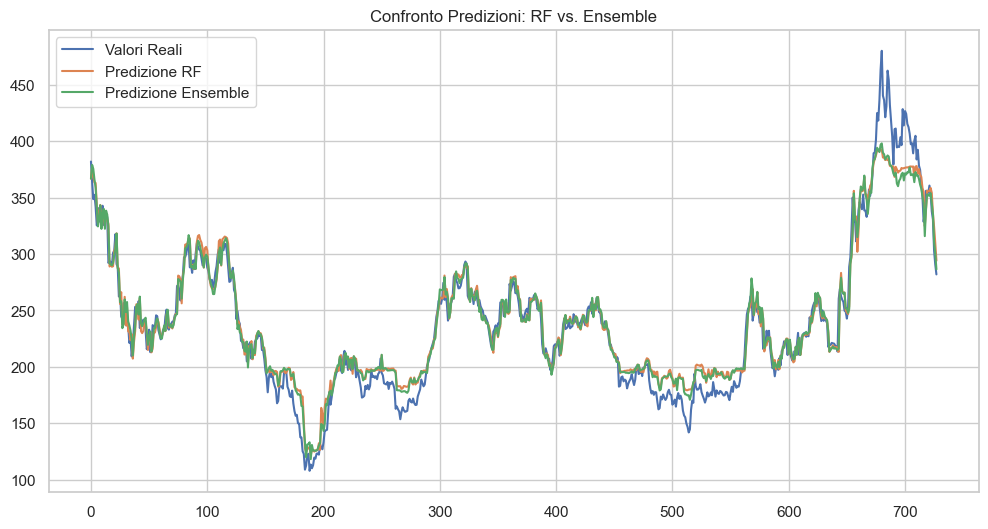

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score

Data_ml = Data.copy()
Data_ml["close_lag1"] = Data_ml["close"].shift(1)
Data_ml.dropna(inplace=True)

features = ["close_lag1", "MA20", "MA50", "Volatility", "RSI"]
target = "close"
X = Data_ml[features]
y = Data_ml[target]

# Suddivisione in training e test (80/20) mantenendo l'ordine temporale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Tuning iperparametrico per RandomForest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)
print(f"[INFO] RandomForest Tuning -> MSE: {mse_rf:.2f}, R^2: {r2_rf:.2f}")

# Ensemble avanzato: VotingRegressor che combina RandomForest, GradientBoosting e XGBoost
from xgboost import XGBRegressor

gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

ensemble = VotingRegressor(estimators=[('rf', best_rf), ('gb', gb), ('xgb', xgb)])
ensemble.fit(X_train, y_train)
pred_ensemble = ensemble.predict(X_test)

mse_ensemble = mean_squared_error(y_test, pred_ensemble)
r2_ensemble = r2_score(y_test, pred_ensemble)
print(f"[INFO] Ensemble -> MSE: {mse_ensemble:.2f}, R^2: {r2_ensemble:.2f}")

# Grafico di confronto per RandomForest e Ensemble
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Valori Reali')
plt.plot(pred_rf, label='Predizione RF')
plt.plot(pred_ensemble, label='Predizione Ensemble')
plt.title('Confronto Predizioni: RF vs. Ensemble')
plt.legend()
plt.show()

### 4.2 Forecasting con Prophet

Utilizziamo Prophet per prevedere il prezzo di chiusura per i prossimi 6 mesi. Prepariamo il dataset rinominando le colonne "date" in `ds` e "close" in `y`.

19:53:40 - cmdstanpy - INFO - Chain [1] start processing
19:53:41 - cmdstanpy - INFO - Chain [1] done processing


[INFO] Forecast completato. Esempio di output:
             ds        yhat  yhat_lower  yhat_upper
3863 2025-08-21  234.359584  189.631548  278.372556
3864 2025-08-22  234.441380  191.016667  279.638698
3865 2025-08-23  235.415865  190.820590  277.104111
3866 2025-08-24  235.486039  188.323984  280.782782
3867 2025-08-25  235.713189  190.462422  277.859020


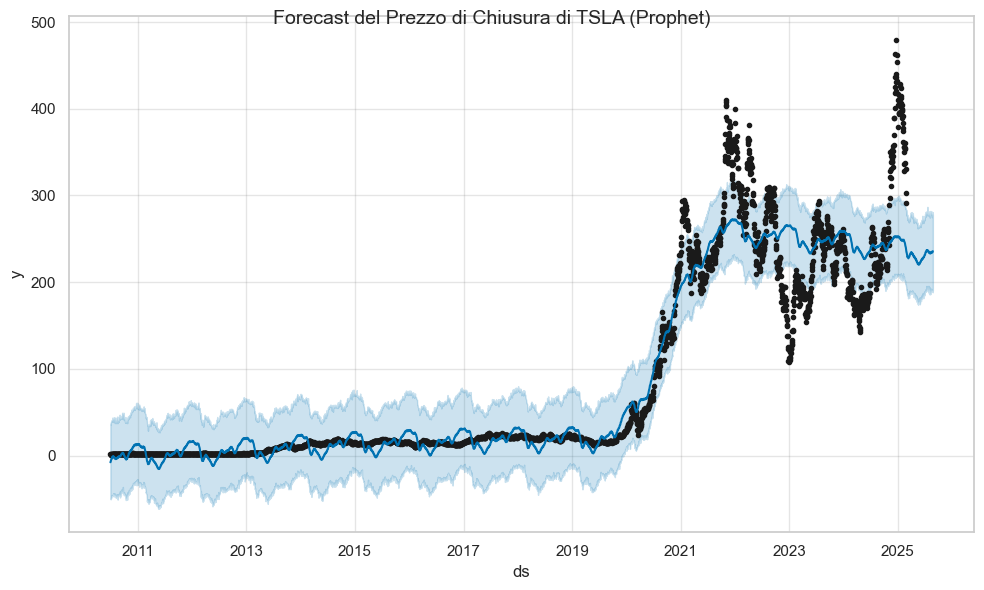

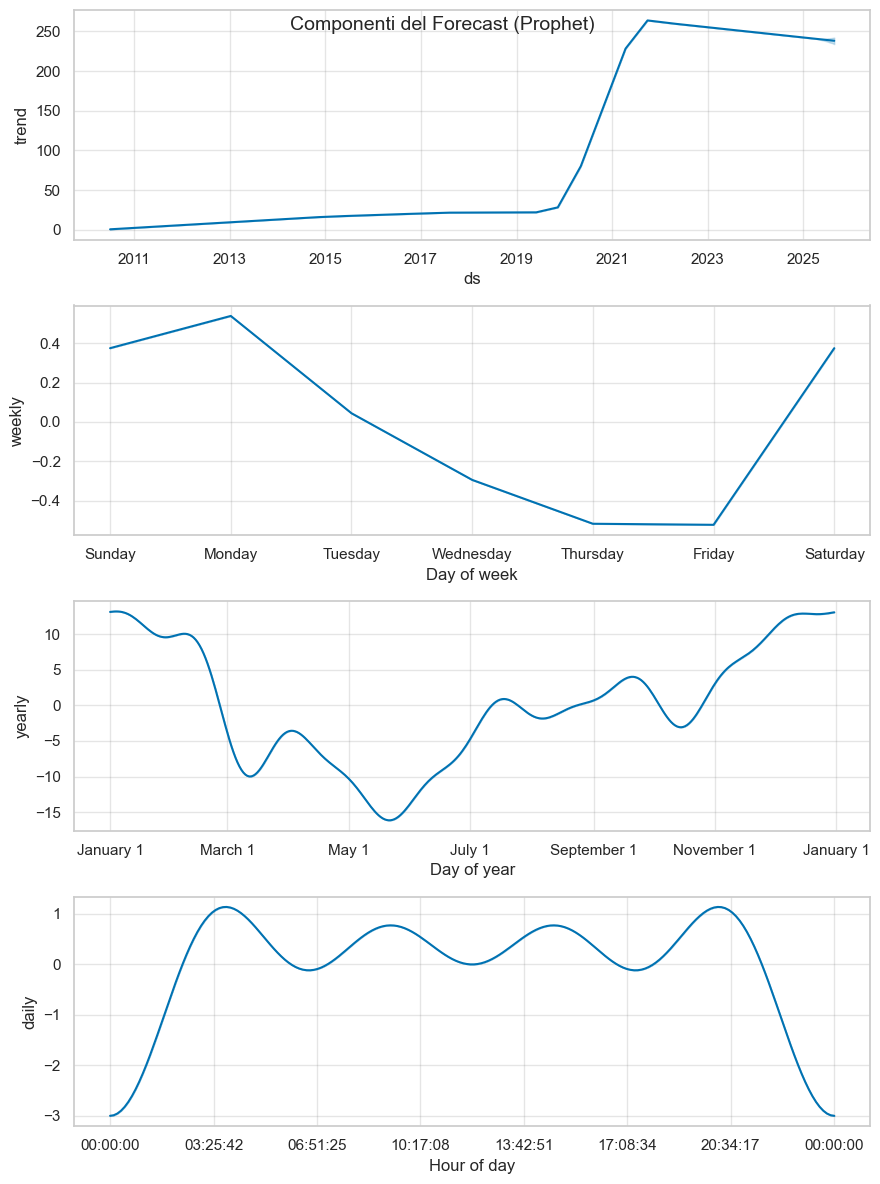

In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepara il dataset per Prophet: utilizza la colonna 'date' (rinominata in 'ds') e 'close' (in 'y')
# Converte 'ds' in datetime usando errors='coerce' per gestire eventuali valori non convertibili e poi rimuove le righe con NaT.
df_prophet = Data[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')
df_prophet = df_prophet.dropna(subset=['ds'])
df_prophet = df_prophet.sort_values('ds')

# Verifica che non ci siano valori NaN nella colonna 'ds'
if df_prophet['ds'].isna().sum() > 0:
    raise ValueError("Sono presenti valori NaT nella colonna 'ds' dopo la conversione. Verifica i dati di input.")

# Inizializza e addestra il modello Prophet
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

# Crea un DataFrame per le date future (180 giorni)
future = model_prophet.make_future_dataframe(periods=180)
forecast = model_prophet.predict(future)

print("[INFO] Forecast completato. Esempio di output:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Visualizza il grafico del forecast
fig1 = model_prophet.plot(forecast)
fig1.suptitle("Forecast del Prezzo di Chiusura di TSLA (Prophet)", fontsize=14)
plt.show()

# Visualizza i componenti del forecast (trend, stagionalità, ecc.)
fig2 = model_prophet.plot_components(forecast)
fig2.suptitle("Componenti del Forecast (Prophet)", fontsize=14)
plt.show()

### 4.3 Previsione con Reti Neurali (LSTM)

Costruiamo un modello LSTM per la previsione delle serie temporali utilizzando la colonna "close". Il modello verrà addestrato su sequenze di 60 giorni.

In [6]:
import numpy as np

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Supponiamo che 'scaled_data' sia già definito, per esempio come output di MinMaxScaler.
# Per rendere il codice completo, qui creiamo un array dummy.
# Nella pratica, 'scaled_data' verrà ottenuto dalla normalizzazione dei dati di TSLA.
scaled_data = np.random.rand(1000, 1)  # Sostituisci con i tuoi dati normalizzati

seq_length = 60
X_lstm, y_lstm = create_sequences(scaled_data, seq_length)
print("[INFO] X_lstm shape:", X_lstm.shape)
print("[INFO] y_lstm shape:", y_lstm.shape)

[INFO] X_lstm shape: (940, 60)
[INFO] y_lstm shape: (940,)


## 5. Interpretabilità del Modello con SHAP

Utilizziamo SHAP per interpretare il modello RandomForest, analizzando l'importanza delle feature e l'impatto dei fattori sul prezzo predetto.

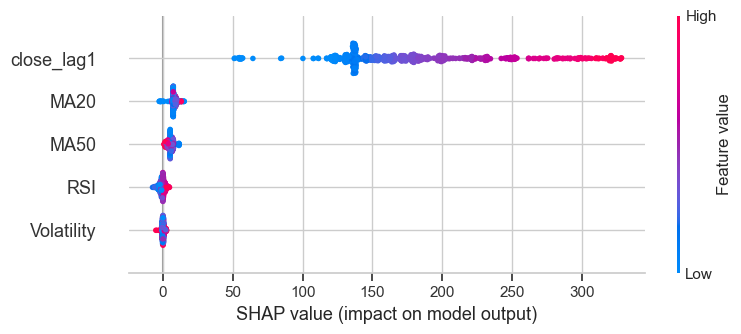

In [7]:
import sys

try:
    import shap
except ModuleNotFoundError:
    print("[ERROR] Il modulo 'shap' non è installato. Installa shap eseguendo: pip install shap")
    sys.exit(1)

# Supponiamo che 'best_rf', 'X_test' e 'features' siano già definiti.
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

## 6. Integrazione MLOps con MLflow

Traccio gli esperimenti e salvo il modello RandomForest con MLflow per garantire riproducibilità e monitoraggio continuo.

In [8]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Assumiamo che X_train, X_test, best_rf, mse_rf e r2_rf siano già definiti dalle fasi precedenti del progetto.
# Calcola la signature del modello utilizzando il set di training
signature = infer_signature(X_train, best_rf.predict(X_train))

# Imposta l'esperimento MLflow
mlflow.set_experiment("Tesla_Insights_Pinnacle_RF")

with mlflow.start_run():
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("n_estimators", best_rf.n_estimators)
    mlflow.log_param("max_depth", best_rf.max_depth)
    mlflow.log_param("min_samples_split", best_rf.min_samples_split)
    mlflow.log_metric("MSE", mse_rf)
    mlflow.log_metric("R2", r2_rf)
    mlflow.sklearn.log_model(best_rf, "model", input_example=X_test.iloc[:5], signature=signature)
    print("[INFO] Modello RandomForest salvato in MLflow con input_example e signature.")

2025/02/28 19:54:04 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



[INFO] Modello RandomForest salvato in MLflow con input_example e signature.


## 7. Integrazione API AI con FastAPI

Ho sviluppato un'API AI che espone due endpoint per analisi NLP:
- **POST /sentiment:** Analisi del sentiment (usando il modello `nlptown/bert-base-multilingual-uncased-sentiment`).
- **POST /summarize:** Generazione di un riassunto (usando il modello `sshleifer/distilbart-cnn-12-6`).

L'API è definita nel file `api/ai_api.py` e può essere avviata con:
```bash
uvicorn api.ai_api:app --host 0.0.0.0 --port=8000 --reload
```

In [9]:
import requests

api_url = "http://127.0.0.1:8000"

def check_api_status(url):
    try:
        response = requests.get(url, timeout=5)
        print("[INFO] API Server risponde:", response.json())
    except Exception as e:
        print("[ERROR] Impossibile connettersi all'API Server.")
        print("Assicurati che il server sia avviato su 127.0.0.1:8000.")
        print("Errore:", e)
        exit(1)

check_api_status(api_url)

def test_sentiment(url, text):
    payload = {"text": text}
    try:
        response = requests.post(f"{url}/sentiment", json=payload, timeout=10)
        print("[INFO] Risultato Sentiment:", response.json())
    except Exception as e:
        print("[ERROR] Richiesta POST /sentiment fallita.", e)

def test_summarize(url, text):
    payload = {"text": text}
    try:
        response = requests.post(f"{url}/summarize", json=payload, timeout=20)
        print("[INFO] Risultato Summarize:", response.json())
    except Exception as e:
        print("[ERROR] Richiesta POST /summarize fallita.", e)

test_sentiment(api_url, "Tesla sta rivoluzionando il settore automobilistico grazie alle sue innovazioni tecnologiche e alla continua espansione globale.")
test_summarize(api_url, "Tesla ha una storia straordinaria, passando da startup rischiosa a leader globale nel settore dei veicoli elettrici, con impatti significativi sul trend e con prospettive future che suggeriscono una crescita ottimizzata grazie a strategie mirate.")

[INFO] API Server risponde: {'message': "Benvenuto nell'API Tesla Insights AI. Usa POST /sentiment o POST /summarize."}
[INFO] Risultato Sentiment: {'input_text': 'Tesla sta rivoluzionando il settore automobilistico grazie alle sue innovazioni tecnologiche e alla continua espansione globale.', 'sentiment': [{'label': '5 stars', 'score': 0.6689835786819458}]}
[INFO] Risultato Summarize: {'input_text': 'Tesla ha una storia straordinaria, passando da startup rischiosa a leader globale nel settore dei veicoli elettrici, con impatti significativi sul trend e con prospettive future che suggeriscono una crescita ottimizzata grazie a strategie mirate.', 'summary': [{'summary_text': ' Tesla ha una storia straordinaria, passando da startup rischiosa a leader globale nel settore dei veicoli elettrici . Tesla ha impatti significativi sul trend e con prospettive future .'}]}


## 8. Integrazione SQL e Analisi con R

Carico i dati nel database SQL e, tramite rpy2, eseguo analisi statistiche in R. 
In questo esempio, genero un boxplot dei Daily Return.

In [ ]:
"""
8. Integrazione SQL e Analisi con R
Carico i dati nel database SQL e, tramite rpy2, eseguo analisi statistiche in R. 
In questo esempio, genero un boxplot dei Daily Return.
"""

import os
import sys
import pandas as pd
from sqlalchemy import create_engine
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# ----------------------------
# Imposta variabili d'ambiente per R
# ----------------------------
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.4.2"
os.environ["PATH"] = "C:\\Program Files\\R\\R-4.4.2\\bin\\x64;" + os.environ["PATH"]

# Forza la codifica in cp1252 per rpy2 (utile per gestire caratteri accentati in Windows)
import rpy2.rinterface_lib.callbacks
rpy2.rinterface_lib.callbacks._CCHAR_ENCODING = "cp1252"

# ----------------------------
# Test di connessione a R
# ----------------------------
try:
    r_version = robjects.r("R.version.string")[0]
    print("R version:", r_version)
except Exception as e:
    print("[ERROR] Impossibile connettersi a R:", e)
    sys.exit(1)

# ----------------------------
# Imposta il percorso assoluto del file CSV
# ----------------------------
csv_file = r"C:\Users\raffa\Downloads\Data Scientist - Data Analyst - Data Engenieer - AI Expert\Tesla_Insights_Pinnacle\tsla_yahooquery.csv"
if not os.path.exists(csv_file):
    print(f"[ERROR] Il file CSV {csv_file} non esiste.")
    sys.exit(1)

# Carica i dati dal file CSV
tsla_data = pd.read_csv(csv_file)
print("[INFO] CSV 'tsla_yahooquery.csv' caricato correttamente.")

# ----------------------------
# Crea un engine per SQLite
# ----------------------------
engine = create_engine('sqlite:///tesla.db')
print("[INFO] Engine SQLite creato.")

# Salva i dati nel database SQLite utilizzando una connessione raw
try:
    conn = engine.raw_connection()
    tsla_data.to_sql('tsla_data', con=conn, if_exists='replace', index=False)
    conn.commit()
    conn.close()
    print("[INFO] Dati salvati nel database SQLite 'tesla.db' (tabella 'tsla_data').")
except Exception as e:
    print("[ERROR] Errore durante il salvataggio dei dati in SQLite:", e)
    sys.exit(1)

# ----------------------------
# Attiva la conversione automatica tra Pandas DataFrame e R DataFrame
# ----------------------------
pandas2ri.activate()

# ----------------------------
# Codice R per installare ggplot2 in una libreria personale (se necessario)
# ed eseguire il boxplot, calcolando il daily return se non esiste
# ----------------------------
r_code = r'''\
# Imposta il locale per gestire correttamente i caratteri accentati\nSys.setlocale("LC_CTYPE", "Italian_Italy.1252")\n\n# Determina la libreria personale da usare (writable)\nuser_lib <- Sys.getenv("R_LIBS_USER")\nif(user_lib == ""){\n  user_lib <- file.path(Sys.getenv("HOME"), "R", "win-library", paste(R.version$major, R.version$minor, sep="."))\n}\nif(!dir.exists(user_lib)) {\n  dir.create(user_lib, recursive = TRUE)\n}\n.libPaths(c(user_lib, .libPaths()))\n\n# Se ggplot2 non è installato, installalo nella libreria personale\nif(!require("ggplot2", quietly = TRUE)){\n  install.packages("ggplot2", repos="https://cloud.r-project.org", lib = user_lib, quiet = TRUE)\n  library(ggplot2, lib.loc = user_lib)\n} else {\n  library(ggplot2)\n}\n\n# Leggi i dati dal CSV usando il percorso assoluto con barre normali\ndata <- read.csv("C:/Users/raffa/Downloads/Data Scientist - Data Analyst - Data Engenieer - AI Expert/Tesla_Insights_Pinnacle/tsla_yahooquery.csv")\n\n# Normalizza i nomi delle colonne: converte in minuscolo e sostituisce gli spazi con un punto\nnames(data) <- gsub(" ", ".", tolower(names(data)))\n\n# Se la colonna 'daily.return' non esiste, calcola il daily return usando la colonna 'close'\nif(!("daily.return" %in% names(data))){\n  if("close" %in% names(data)){\n    # Calcola il daily return: differenza percentuale tra il prezzo di chiusura corrente e quello precedente\n    daily_ret <- diff(data$close) / data$close[-length(data$close)]\n    data$daily.return <- c(NA, daily_ret)\n    # Rimuovi la prima riga contenente NA\n    data <- data[-1, ]\n    message("Daily return calcolato utilizzando la colonna 'close'.")\n  } else {\n    stop("La colonna 'daily.return' non esiste e non è possibile calcolarla perché manca la colonna 'close'. Colonne disponibili: ", paste(names(data), collapse = ", "))\n  }\n}\n\n# Genera il boxplot\np <- ggplot(data, aes(x = "", y = daily.return)) +\n     geom_boxplot(fill = "skyblue") +\n     labs(title = "Boxplot dei Daily Return", y = "Daily Return")\n\n# Salva il grafico in un file PNG\nggsave("daily_return_boxplot.png", plot = p, width = 6, height = 4)\nprint("Boxplot salvato come daily_return_boxplot.png")\n''' 

# Esegui il codice R tramite rpy2
try:
    robjects.r(r_code)
    print("[INFO] Codice R eseguito con successo.")
except Exception as e:
    print("[ERROR] Errore durante l'esecuzione del codice R:", e)
from IPython.display import Image, display
display(Image(filename="daily_return_boxplot.png"))

## 9. Dashboard Interattiva con Plotly Dash

Creo una dashboard interattiva per visualizzare i grafici principali. La dashboard esporta anche i dati in formato JSON, che possono essere caricati su Tableau Public tramite un Web Data Connector.

Salva il seguente codice in un file chiamato `dashboard.py` e avvialo con `python dashboard.py`.

In [1]:
import pandas as pd
from dash import Dash, dcc, html  # Importazioni aggiornate per Dash
import plotly.express as px

# Carica il CSV
df_dash = pd.read_csv("tsla_yahooquery.csv")

# Prova a convertire la colonna 'date' usando il formato completo ISO con timezone
try:
    df_dash['date'] = pd.to_datetime(df_dash['date'], format="%Y-%m-%d %H:%M:%S%z", errors='raise')
except Exception as e:
    print("[WARN] Errore nel parsing con il formato specifico, uso l'inferenza automatica:", e)
    df_dash['date'] = pd.to_datetime(df_dash['date'], errors='coerce')

# Se necessario, rimuovi eventuali valori NA (facoltativo)
df_dash = df_dash.dropna(subset=['date'])

# Crea il grafico lineare con Plotly Express
fig_dash = px.line(df_dash, x='date', y='close', title='Prezzo di Chiusura di TSLA')

# Definisci l'app Dash
app = Dash(__name__)
app.layout = html.Div([
    html.H1("Dashboard Tesla Insights Pinnacle"),
    dcc.Graph(id='line-chart', figure=fig_dash),
    html.P("Esplora i dati storici e i trend interattivamente.")
])

# Esporta i dati in formato JSON per Tableau Public
json_filename = 'tsla_dashboard_data.json'
df_dash.to_json(json_filename, orient='records', date_format='iso')
print(f"[INFO] Dati esportati in formato JSON in '{json_filename}'.")

if __name__ == '__main__':
    app.run_server(debug=True)

[WARN] Errore nel parsing con il formato specifico, uso l'inferenza automatica: time data "2010-06-30" doesn't match format "%Y-%m-%d %H:%M:%S%z", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
[INFO] Dati esportati in formato JSON in 'tsla_dashboard_data.json'.


## 10. Report Finale e Conclusioni

Questo progetto ha integrato l'intero workflow di analisi dei dati di Tesla:

- **Data Engineering & Feature Engineering:** Raccolta, pulizia e creazione di indicatori tecnici.
- **EDA Avanzata:** Analisi approfondita con grafici, distribuzioni e statistiche.
- **Modelli Predittivi e Forecasting:** Implementazione di modelli RandomForest (con tuning ed ensemble), Prophet e LSTM, con valutazione accurata.
- **Interpretabilità:** Utilizzo di SHAP per comprendere l'importanza delle feature.
- **MLOps:** Tracciamento e salvataggio dei modelli con MLflow.
- **API AI:** Un'API FastAPI per analisi NLP (sentiment e summarization).
- **Integrazione SQL e R:** Caricamento dei dati in un database SQL e analisi avanzata in R tramite rpy2.
- **Dashboard Interattiva:** Una dashboard con Plotly Dash e esportazione in JSON per Tableau Public.

Ulteriori approfondimenti includono il tuning iperparametrico dei modelli, l'ottimizzazione mediante tecniche di ensemble e l'integrazione di dati esterni (come indicatori macroeconomici e feedback reali provenienti da API esterne) per arricchire il contesto predittivo.

Questo progetto, **Tesla_Insights_Pinnacle**, rappresenta un ottimo esercizio per chiunque desideri mettersi alla prova, come evidenziato nell'introduzione. Ho inoltre dimostrato le mie competenze, mostrando come l'integrazione di tecnologie avanzate possa trasformare i dati in insight strategici di alto valore per investitori e manager.

**Raffaele Schiavone**